for this task Ravdess dataset was used
RAVDESS  https://zenodo.org/record/1188976 : The Ryson Audio-Visual Database of Emotional Speech and Song that contains 24 actors (12 male, 12 female), vocalizing two lexically-matched statements in a neutral North American accent.

In [3]:
import pandas as pd
import numpy as np
import os
import struct
import matplotlib.pyplot as plt
import librosa
import librosa.display
import soundfile as sf
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split 
from tensorflow.keras.utils import to_categorical
from IPython.display import Audio, display
import IPython.display as ipd
from sklearn.model_selection import train_test_split
from tensorflow import keras 
from torch.utils.data import Dataset, DataLoader
from tensorflow import keras
from torch.utils.data import Dataset
import pandas as pd
import torchaudio
from tqdm import tqdm
import torch
from torch.autograd import Variable
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
import soundfile
from torch import nn
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv1D, MaxPool1D, BatchNormalization
from tensorflow.keras.optimizers import RMSprop,Adam
from torchsummary import summary

### Overview

#### Functions

In [4]:
def read_wav_file(path, file):
    data, samplerate = sf.read(path+file)
    return data, samplerate

### Choosing the Dataset

We've choose RAVDESS dataset ..... <br>

Each of the 7356 RAVDESS files has a unique filename. The filename consists of a 7-part numerical identifier (e.g., 02-01-06-01-02-01-12.mp4). These identifiers define the stimulus characteristics: <br>

Filename identifiers 
<ul>
    <li>Modality (01 = full-AV, 02 = video-only, 03 = audio-only).</li>
    <li>Vocal channel (01 = speech, 02 = song).</li>
    <li>Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).</li>
    <li>Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.</li>
    <li>Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").</li>
    <li>Repetition (01 = 1st repetition, 02 = 2nd repetition).</li>
    <li>Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).</li>
<ul>


Speech includes calm, happy, sad, angry, fearful, surprise, and disgust expressions, and song contains calm, happy, sad, angry, and fearful emotions.

In [5]:
emotions = {1: 'neutral', 2: 'calm', 3: 'happy', 4: 'sad', 5: 'angry', 6: 'fearful', 7: 'disgust', 8: 'surprised'}

For comfort(наверное по другому) we create a data frame with representing all meta data:

In [6]:
columns = ['File', 'Modality', 'Vocal', 'Emotion', 'Intensity', 'Statement', 'Repetition', 'Actor']
df_meta = pd.DataFrame(columns = columns)

In [7]:
path = r"Actors/"
[dir for dir in os.listdir(path) if dir.startswith('Actor_')]

['Actor_1',
 'Actor_10',
 'Actor_11',
 'Actor_12',
 'Actor_13',
 'Actor_14',
 'Actor_15',
 'Actor_16',
 'Actor_17',
 'Actor_18',
 'Actor_19',
 'Actor_2',
 'Actor_20',
 'Actor_21',
 'Actor_22',
 'Actor_23',
 'Actor_24',
 'Actor_3',
 'Actor_4',
 'Actor_5',
 'Actor_6',
 'Actor_7',
 'Actor_8',
 'Actor_9']

### Feature extraction

In [8]:
actors = [dir for dir in os.listdir(path) if dir.startswith('Actor_')]

In [9]:
files = []
for actor in actors:
    files.extend(os.listdir(path+actor))
df_meta['File'] = files
file = files[0]
for i in range(len(files)):
    file = files[i]
    integer_list = list(map(int, file.split('.')[0].split('-')))
    df_meta.loc[i, df_meta.columns[1:]] = integer_list

In [10]:
df_meta[:3]

File Modality Vocal Emotion Intensity Statement  \
0  03-01-01-01-01-01-01.wav        3     1       1         1         1   
1  03-01-01-01-01-02-01.wav        3     1       1         1         1   
2  03-01-01-01-02-01-01.wav        3     1       1         1         2   

  Repetition Actor  
0          1     1  
1          2     1  
2          1     1

In [11]:
df_labels = df_meta

After create this dataset we've extracted features from dataset(df_meta)

In [12]:
'''for row in df_meta.index:
    file = df_meta.loc[row, 'File']
    path_file = path+'Actor_'+str(df_meta.loc[row, 'Actor']).zfill(2)+'/'
    data, sr = read_wav_file(path_file, file)
    df_meta.loc[row, 'Lenght_Data_Array'] = len(data)
    df_meta.loc[row, 'Samplerate'] = sr
df_meta['Seconds'] = df_meta['Lenght_Data_Array']/df_meta['Samplerate']'''

"for row in df_meta.index:\n    file = df_meta.loc[row, 'File']\n    path_file = path+'Actor_'+str(df_meta.loc[row, 'Actor']).zfill(2)+'/'\n    data, sr = read_wav_file(path_file, file)\n    df_meta.loc[row, 'Lenght_Data_Array'] = len(data)\n    df_meta.loc[row, 'Samplerate'] = sr\ndf_meta['Seconds'] = df_meta['Lenght_Data_Array']/df_meta['Samplerate']"

In [14]:
df_meta

File Modality Vocal Emotion Intensity Statement  \
0     03-01-01-01-01-01-01.wav        3     1       1         1         1   
1     03-01-01-01-01-02-01.wav        3     1       1         1         1   
2     03-01-01-01-02-01-01.wav        3     1       1         1         2   
3     03-01-01-01-02-02-01.wav        3     1       1         1         2   
4     03-01-02-01-01-01-01.wav        3     1       2         1         1   
...                        ...      ...   ...     ...       ...       ...   
1435  03-01-08-01-02-02-09.wav        3     1       8         1         2   
1436  03-01-08-02-01-01-09.wav        3     1       8         2         1   
1437  03-01-08-02-01-02-09.wav        3     1       8         2         1   
1438  03-01-08-02-02-01-09.wav        3     1       8         2         2   
1439  03-01-08-02-02-02-09.wav        3     1       8         2         2   

     Repetition Actor  
0             1     1  
1             2     1  
2             1     1  
3             2     1  
4             1     1  
...         ...   ...  
1435          2     9  
1436          1     9  
1437          2     9  
1438          1     9  
1439          2     9  

[1440 rows x 8 columns]

In [15]:
data = pd.read_csv('Ravdess_annotations.csv')
data.head(5)

File  Modality  Vocal  Emotion  Intensity  Statement  \
0  03-01-01-01-01-01-01.wav         3      1  neutral          1          1   
1  03-01-01-01-01-02-01.wav         3      1  neutral          1          1   
2  03-01-01-01-02-01-01.wav         3      1  neutral          1          2   
3  03-01-01-01-02-02-01.wav         3      1  neutral          1          2   
4  03-01-02-01-01-01-01.wav         3      1     calm          1          1   

   Repetition  Actor  Emotion_ID  
0           1      1           1  
1           2      1           1  
2           1      1           1  
3           2      1           1  
4           1      1           2

In [16]:
print(data['Emotion'].value_counts())

sad          192
angry        192
happy        192
disgust      192
fearful      192
surprised    192
calm         192
neutral       96
Name: Emotion, dtype: int64


In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1440 entries, 0 to 1439
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   File        1440 non-null   object
 1   Modality    1440 non-null   int64 
 2   Vocal       1440 non-null   int64 
 3   Emotion     1440 non-null   object
 4   Intensity   1440 non-null   int64 
 5   Statement   1440 non-null   int64 
 6   Repetition  1440 non-null   int64 
 7   Actor       1440 non-null   int64 
 8   Emotion_ID  1440 non-null   int64 
dtypes: int64(7), object(2)
memory usage: 101.4+ KB


In [18]:
print(data.columns)

Index(['File', 'Modality', 'Vocal', 'Emotion', 'Intensity', 'Statement',
       'Repetition', 'Actor', 'Emotion_ID'],
      dtype='object')


### 2. Create custom dataset and dataloader

In [19]:
SAMPLE_RATE = 48000
NUM_SAMPLES = 48000

In [20]:
class Ravdess(Dataset):

    def __init__(self,
                 annotations_file,
                 audio_dir,
                 transformation,
                 target_sample_rate,
                 num_samples,
                 device):
        self.annotations = pd.read_csv(annotations_file)
        self.audio_dir = audio_dir
        self.device = device
        self.transformation = transformation.to(self.device)
        self.target_sample_rate = target_sample_rate
        self.num_samples = num_samples

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        audio_sample_path = self._get_audio_sample_path(index)
        label = self._get_audio_sample_label(index)
        signal, sr = torchaudio.load(audio_sample_path)
        signal = signal.to(self.device)
        signal = self._resample_if_necessary(signal, sr)
        signal = self._mix_down_if_necessary(signal)
        signal = self._cut_if_necessary(signal)
        signal = self._right_pad_if_necessary(signal)
        signal = self.transformation(signal)
        return signal, label

    def _cut_if_necessary(self, signal):
        if signal.shape[1] > self.num_samples:
            signal = signal[:, :self.num_samples]
        return signal

    def _right_pad_if_necessary(self, signal):
        length_signal = signal.shape[1]
        if length_signal < self.num_samples:
            num_missing_samples = self.num_samples - length_signal
            last_dim_padding = (0, num_missing_samples)
            signal = torch.nn.functional.pad(signal, last_dim_padding)
        return signal

    def _resample_if_necessary(self, signal, sr):
        if sr != self.target_sample_rate:
            resampler = torchaudio.transforms.Resample(sr, self.target_sample_rate)
            signal = resampler(signal)
        return signal

    def _mix_down_if_necessary(self, signal):
        if signal.shape[0] > 1:
            signal = torch.mean(signal, dim=0, keepdim=True)
        return signal

    def _get_audio_sample_path(self, index):
        actor = f"Actor_{self.annotations.iloc[index, 7]}"
        path = os.path.join(self.audio_dir, actor, self.annotations.iloc[
            index, 0])
        return path

    def _get_audio_sample_label(self, index):
        return self.annotations.iloc[index, 3]
    
        
n_fft = 1024
hop_length = 512
n_mels = 64
win_length = None
n_mfcc = 40

mfcc_transform = torchaudio.transforms.MFCC(
        sample_rate=SAMPLE_RATE,
        n_mfcc=n_mfcc
    )

    
if __name__ == "__main__":
    ANNOTATIONS_FILE = r"C:\Users\Acer\AppData\Local\Programs\Python\Python37\Scripts\project\annotations.csv"
    AUDIO_DIR = r"C:\Users\Acer\AppData\Local\Programs\Python\Python37\Scripts\project\Actors"
    if torch.cuda.is_available():
        device = "cuda"
    else:
        device = "cpu"
    print(f"Using device {device}")
    rav = Ravdess(ANNOTATIONS_FILE, AUDIO_DIR,mfcc_transform, SAMPLE_RATE, NUM_SAMPLES, device)
    print(f"There are {len(rav)} samples in the dataset.")
    signal, label = rav[0]
    print(label, signal.shape)
    print(label, signal)

c:\users\acer\appdata\local\programs\python\python37\lib\site-packages\torchaudio\functional\functional.py:433: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  "At least one mel filterbank has all zero values. "


Using device cpu
There are 1440 samples in the dataset.
1 torch.Size([1, 40, 241])
1 tensor([[[-9.8760e+02, -1.0952e+03, -1.1233e+03,  ..., -7.5216e+02,
          -8.0574e+02, -8.1998e+02],
         [-6.8750e+01, -2.2280e+01,  5.2746e-05,  ..., -1.0768e+02,
          -6.5550e+01, -7.0405e+01],
         [ 1.0791e+00,  9.1956e+00, -4.2397e-05,  ..., -4.7773e+01,
          -3.0437e+01, -2.0128e+01],
         ...,
         [-1.9381e+00, -1.1513e+00,  1.2541e-04,  ..., -2.1635e+01,
          -1.5010e+01, -8.6703e+00],
         [ 4.3960e-01,  4.4531e-01, -3.1399e-04,  ..., -6.4258e+00,
          -1.5566e+01, -2.1336e+01],
         [ 2.7812e+00, -6.3171e-01, -2.7847e-04,  ..., -1.5479e+00,
          -3.6826e+00, -1.1471e+01]]])


In [21]:
data_loader = torch.utils.data.DataLoader(rav,batch_size=1,shuffle=True)

In [22]:
%%time
for i, (inputs, targets) in enumerate(data_loader):
    with torch.no_grad():
        inputs = Variable(inputs)
        targets = Variable(targets)
        print(inputs, targets)

tensor([[[[-9.3197e+02, -8.7794e+02, -9.1647e+02,  ..., -8.1692e+02,
           -8.1171e+02, -8.3500e+02],
          [-6.0290e+01, -3.9993e+01, -5.5831e+01,  ..., -6.6829e+01,
           -7.8667e+01, -8.1560e+01],
          [-2.6698e+01, -5.1621e+01, -2.6093e+01,  ..., -2.7998e+01,
           -2.1675e+01, -2.3878e+01],
          ...,
          [-1.3039e+01, -7.8811e+00, -4.4724e+00,  ..., -6.6535e+00,
           -1.2740e+01, -1.0971e+01],
          [-1.4722e+01, -3.4411e+00, -5.9281e+00,  ..., -9.3830e+00,
           -1.3167e+01, -1.1488e+01],
          [ 8.0526e+00, -5.9593e+00, -3.2784e+00,  ..., -1.5583e+01,
           -8.1118e+00, -8.6220e-01]]]]) tensor([3])
tensor([[[[-1.1314e+03, -1.1314e+03, -1.1314e+03,  ..., -8.4056e+02,
           -8.5075e+02, -8.1860e+02],
          [ 9.6589e-05,  9.6589e-05,  9.6589e-05,  ..., -7.9402e+01,
           -6.8158e+01, -7.0717e+01],
          [-6.9946e-05, -6.9946e-05, -6.9946e-05,  ..., -1.4355e+01,
           -2.2365e+01, -2.1392e+01],
       

### 3 Exploratory Data Analysis



In [23]:
def print_stats(waveform, sample_rate=None, src=None):
    if src:
        print("-" * 10)
        print("Source:", src)
        print("-" * 10)
    if sample_rate:
        print("Sample Rate:", sample_rate)
        print("Shape:", tuple(waveform.shape))
        print("Dtype:", waveform.dtype)
        print(f" - Max:     {waveform.max().item():6.3f}")
        print(f" - Min:     {waveform.min().item():6.3f}")
        print(f" - Mean:    {waveform.mean().item():6.3f}")
        print(f" - Std Dev: {waveform.std().item():6.3f}")

In [24]:
audio_path = r"C:\Users\Acer\AppData\Local\Programs\Python\Python37\Scripts\project\Actors\Actor_1\03-01-01-01-01-01-01.wav"
waveform, sample_rate = torchaudio.load(audio_path)
print_stats(waveform, sample_rate=sample_rate)

Sample Rate: 48000
Shape: (1, 158558)
Dtype: torch.float32
 - Max:      0.041
 - Min:     -0.038
 - Mean:     0.000
 - Std Dev:  0.004


In [25]:
metadata = torchaudio.info(audio_path)
print (metadata)

AudioMetaData(sample_rate=48000, num_frames=158558, num_channels=1, bits_per_sample=16, encoding=PCM_S)


In [26]:
ipd.Audio(audio_path)

### Zero-Crossings

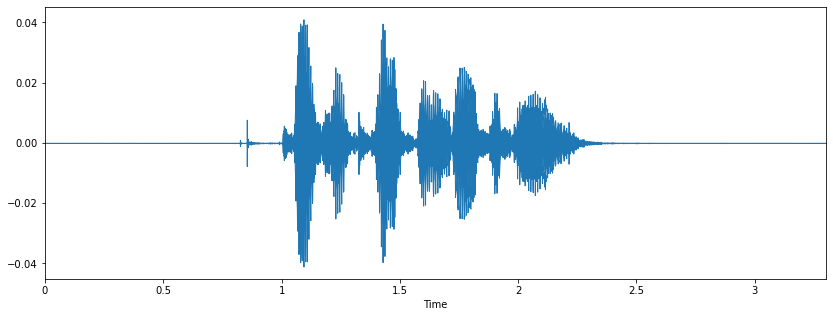

In [27]:
x, sr = librosa.load(audio_path)
plt.figure(figsize=(14, 5))
librosa.display.waveplot(x, sr=sr)

In [28]:
import matplotlib.pyplot as plt 

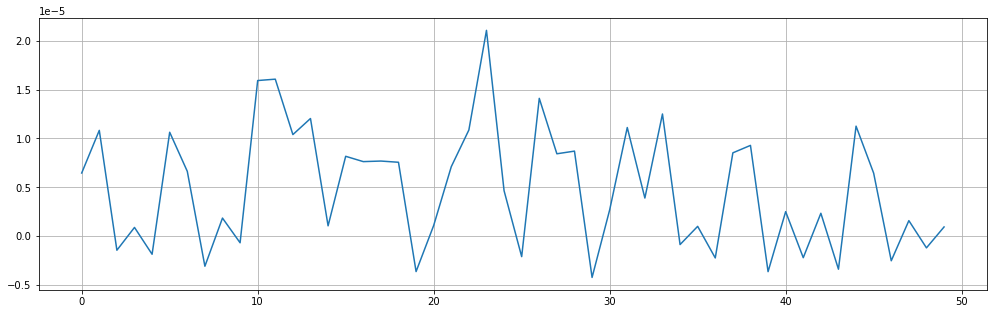

In [29]:
n0 = 6900
n1 = 6950
plt.figure(figsize=(17, 5))
plt.plot(x[n0:n1])
plt.grid()

In [30]:
zero_crossings = librosa.zero_crossings(x[n0:n1], pad=False)
print(sum(zero_crossings))

28


### Spectral Centroid

<Figure size 1008x360 with 0 Axes>

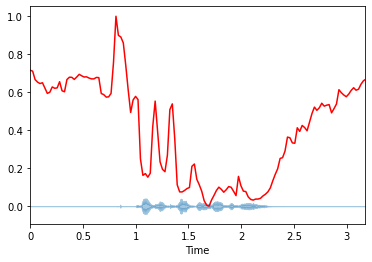

<Figure size 1008x360 with 0 Axes>

In [31]:
import sklearn
spectral_centroids = librosa.feature.spectral_centroid(x, sr=sr)[0]

frames = range(len(spectral_centroids))
t = librosa.frames_to_time(frames)
def normalize(x, axis=0):
    return sklearn.preprocessing.minmax_scale(x, axis=axis)
librosa.display.waveplot(x[:70000], sr=sr, alpha=0.4)
plt.plot(t, normalize(spectral_centroids), color='r')
plt.figure(figsize=(14, 5))

### Spectral Rolloff

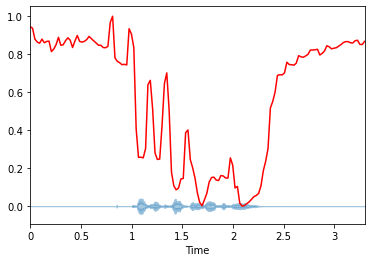

In [32]:
spectral_rolloff = librosa.feature.spectral_rolloff(x, sr=sr)[0]
librosa.display.waveplot(x, sr=sr, alpha=0.4)
plt.plot(t, normalize(spectral_rolloff), color='r')

In [33]:
y, sr =librosa.load(audio_path)

In [34]:
x = librosa.stft(y)
Xdb = librosa.amplitude_to_db(np.abs(x), ref=np.max)

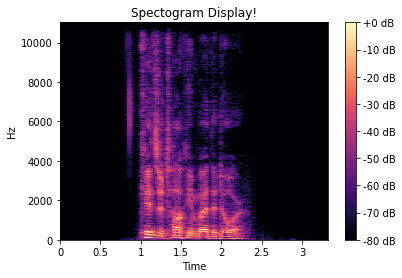

In [35]:
fig, ax = plt.subplots()
img = librosa.display.specshow(Xdb, x_axis='time', y_axis='linear', ax=ax)
ax.set(title='Spectogram Display!')
fig.colorbar(img, ax=ax, format="%+2.f dB")

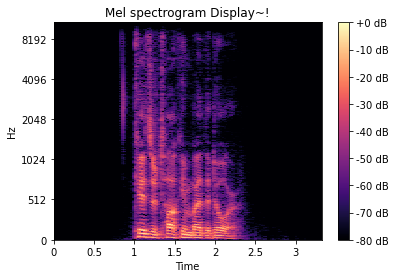

In [36]:
fig, ax = plt.subplots()
M = librosa.feature.melspectrogram(y=y, sr=sr)
M_db = librosa.power_to_db(M, ref=np.max)
img = librosa.display.specshow(Xdb, y_axis='mel', x_axis='time', ax=ax)
ax.set(title='Mel spectrogram Display~!')
fig.colorbar(img, ax=ax, format="%+2.f dB")

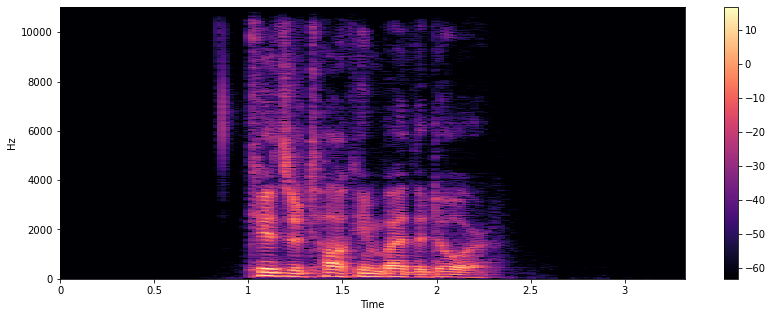

In [37]:
X = librosa.stft(y)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz') 
plt.colorbar()
plt.show()

In [38]:
audio_path1 = r"C:\Users\Acer\AppData\Local\Programs\Python\Python37\Scripts\project\Actors\Actor_1\03-01-06-01-01-01-01.wav"

In [39]:
ipd.Audio(audio_path1)

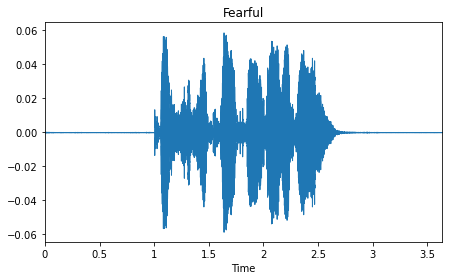

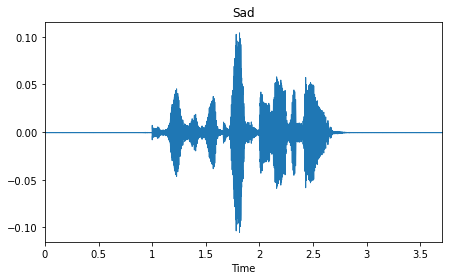

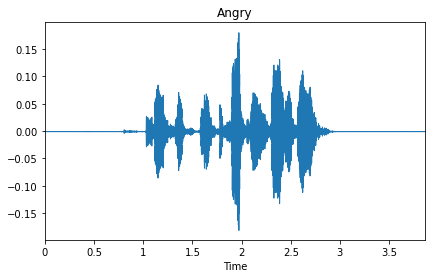

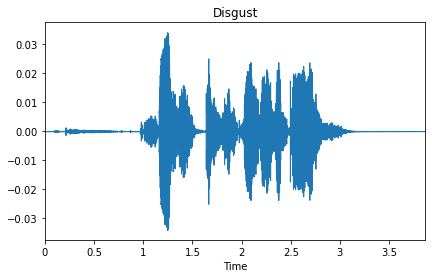

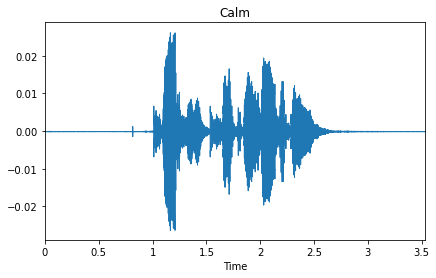

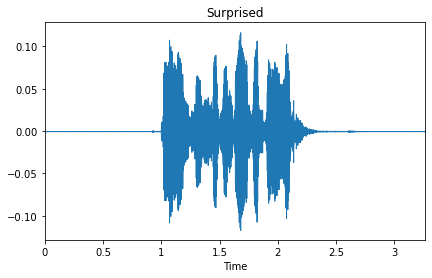

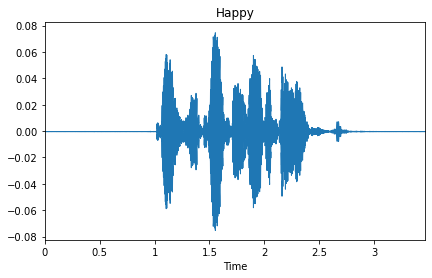

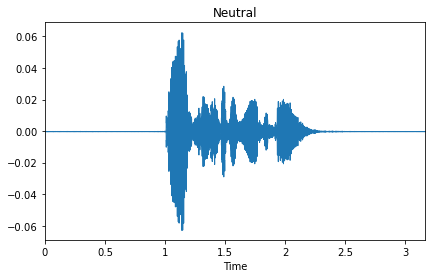

In [40]:
emotion_dir=r"Actors\Actor_1"

with soundfile.SoundFile(os.path.join(emotion_dir, '03-01-06-01-01-02-01.wav')) as audio:
    fearful_waveform = audio.read(dtype="float32")
    neutral_sr = audio.samplerate
    plt.figure(figsize=(12,4))
    plt.subplot(1, 2, 1)
    librosa.display.waveplot(fearful_waveform, sr=neutral_sr)
    plt.title('Fearful', size = 12)
    plt.tight_layout()

with soundfile.SoundFile(os.path.join(emotion_dir, '03-01-04-02-01-02-01.wav')) as audio:
    sad_waveform = audio.read(dtype="float32")
    neutral_sr = audio.samplerate
    plt.figure(figsize=(12,4))
    plt.subplot(1, 2, 1)
    librosa.display.waveplot(sad_waveform, sr=neutral_sr)
    plt.title('Sad', size = 12)
plt.tight_layout()
    
with soundfile.SoundFile(os.path.join(emotion_dir, '03-01-05-01-01-01-01.wav')) as audio:
    angry_waveform = audio.read(dtype="float32")
    neutral_sr = audio.samplerate
    plt.figure(figsize=(15,4))
    plt.subplot(1, 2, 1)
    librosa.display.waveplot(angry_waveform, sr=neutral_sr)
    plt.title('Angry', size = 12)
 

with soundfile.SoundFile(os.path.join(emotion_dir, '03-01-07-01-01-01-01.wav')) as audio:
    disgust_waveform = audio.read(dtype="float32")
    neutral_sr = audio.samplerate
    plt.figure(figsize=(15,4))
    plt.subplot(1, 2, 1)
    librosa.display.waveplot(disgust_waveform, sr=neutral_sr)
    plt.title('Disgust', size = 12)
   
with soundfile.SoundFile(os.path.join(emotion_dir, '03-01-02-01-01-01-01.wav')) as audio:
    calm_waveform = audio.read(dtype="float32")
    neutral_sr = audio.samplerate
    plt.figure(figsize=(15,4))
    plt.subplot(1, 2, 1)
    librosa.display.waveplot(calm_waveform, sr=neutral_sr)
    plt.title('Calm', size = 12)
 

with soundfile.SoundFile(os.path.join(emotion_dir, '03-01-08-02-02-02-01.wav')) as audio:
    surprised_waveform = audio.read(dtype="float32")
    neutral_sr = audio.samplerate
    plt.figure(figsize=(15,4))
    plt.subplot(1, 2, 1)
    librosa.display.waveplot(surprised_waveform, sr=neutral_sr)
    plt.title('Surprised', size = 12)
  

with soundfile.SoundFile(os.path.join(emotion_dir, '03-01-03-01-01-02-01.wav')) as audio:
    happy_waveform = audio.read(dtype="float32")
    neutral_sr = audio.samplerate
    plt.figure(figsize=(15,4))
    plt.subplot(1, 2, 1)
    librosa.display.waveplot(happy_waveform, sr=neutral_sr)
    plt.title('Happy', size = 12)

# example of happy and angry audio files
with soundfile.SoundFile(os.path.join(emotion_dir, '03-01-01-01-02-02-01.wav')) as audio:
    neutral_waveform = audio.read(dtype="float32")
    neutral_sr = audio.samplerate
    plt.figure(figsize=(15,4))
    plt.subplot(1, 2, 1)
    librosa.display.waveplot(neutral_waveform, sr=neutral_sr)
    plt.title('Neutral', size = 12)

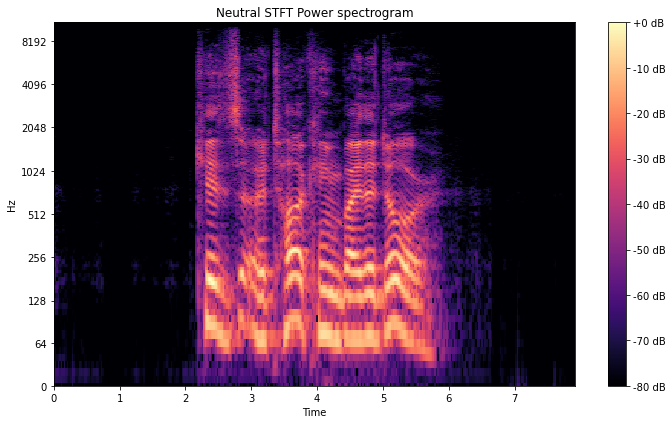

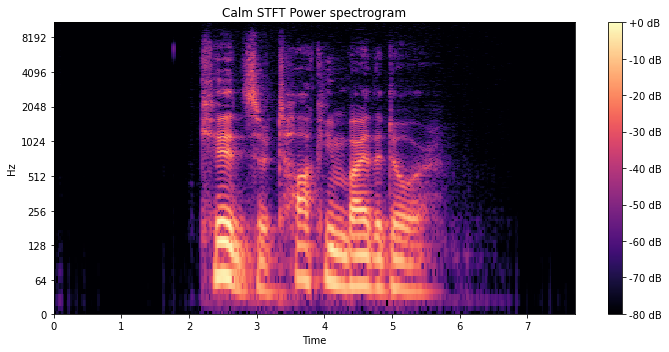

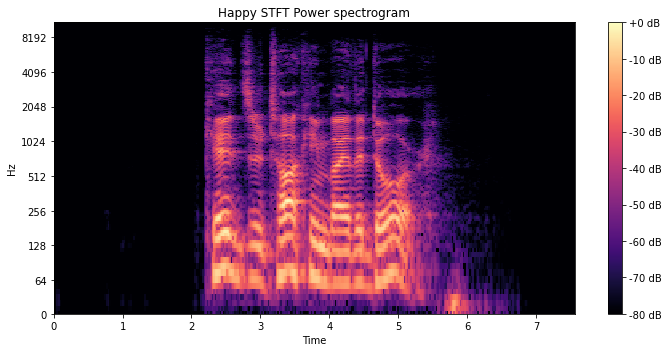

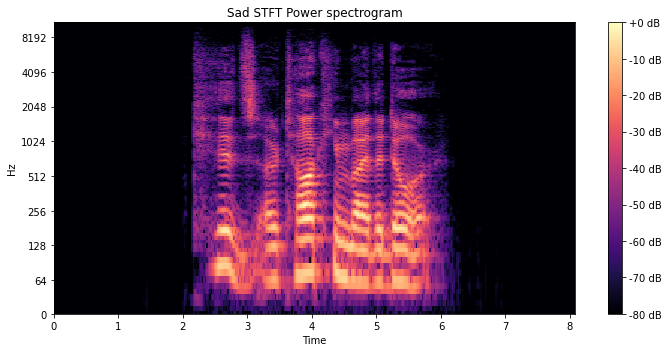

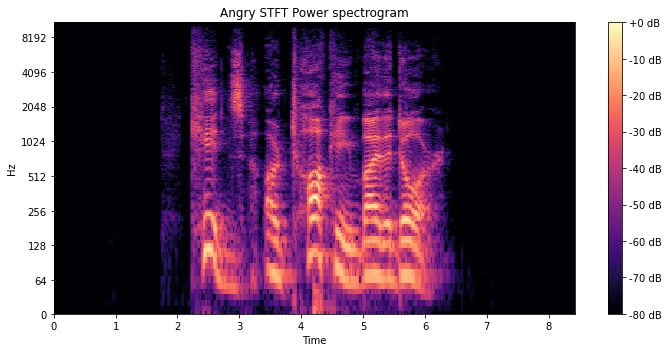

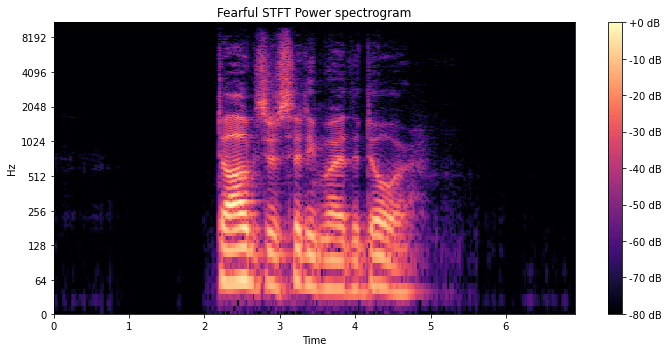

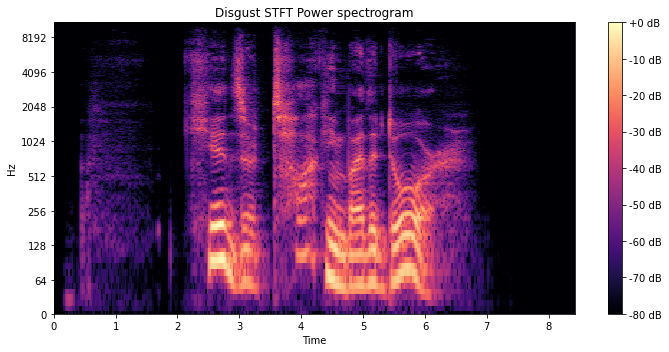

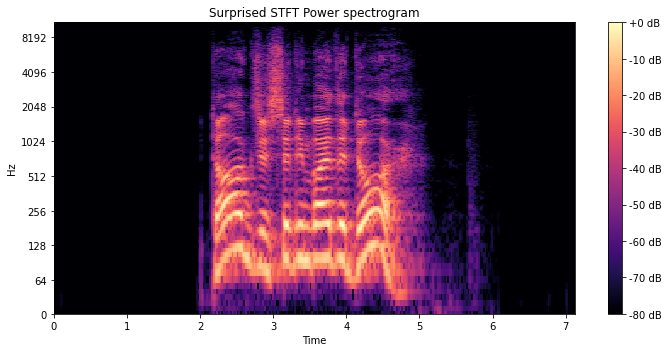

In [41]:
stft_spectrum_matrix = librosa.stft(fearful_waveform)
plt.figure(figsize=(10, 6))
librosa.display.specshow(librosa.amplitude_to_db(np.abs(stft_spectrum_matrix), ref=np.max),y_axis='log', x_axis='time')
plt.title('Neutral STFT Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()

stft_spectrum_matrix = librosa.stft(calm_waveform)
plt.figure(figsize=(10, 5))
librosa.display.specshow(librosa.amplitude_to_db(np.abs(stft_spectrum_matrix), ref=np.max),y_axis='log', x_axis='time')
plt.title('Calm STFT Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()

stft_spectrum_matrix = librosa.stft(happy_waveform)
plt.figure(figsize=(10, 5))
librosa.display.specshow(librosa.amplitude_to_db(np.abs(stft_spectrum_matrix), ref=np.max),y_axis='log', x_axis='time')
plt.title('Happy STFT Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()

stft_spectrum_matrix = librosa.stft(sad_waveform)
plt.figure(figsize=(10, 5))
librosa.display.specshow(librosa.amplitude_to_db(np.abs(stft_spectrum_matrix), ref=np.max),y_axis='log', x_axis='time')
plt.title('Sad STFT Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()

stft_spectrum_matrix = librosa.stft(angry_waveform)
plt.figure(figsize=(10, 5))
librosa.display.specshow(librosa.amplitude_to_db(np.abs(stft_spectrum_matrix), ref=np.max),y_axis='log', x_axis='time')
plt.title('Angry STFT Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()

stft_spectrum_matrix = librosa.stft(neutral_waveform)
plt.figure(figsize=(10, 5))
librosa.display.specshow(librosa.amplitude_to_db(np.abs(stft_spectrum_matrix), ref=np.max),y_axis='log', x_axis='time')
plt.title('Fearful STFT Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()

stft_spectrum_matrix = librosa.stft(disgust_waveform)
plt.figure(figsize=(10, 5))
librosa.display.specshow(librosa.amplitude_to_db(np.abs(stft_spectrum_matrix), ref=np.max),y_axis='log', x_axis='time')
plt.title('Disgust STFT Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()

stft_spectrum_matrix = librosa.stft(surprised_waveform)
plt.figure(figsize=(10, 5))
librosa.display.specshow(librosa.amplitude_to_db(np.abs(stft_spectrum_matrix), ref=np.max),y_axis='log', x_axis='time')
plt.title('Surprised STFT Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()

### Mel-Frequency Cepstral Coefficients

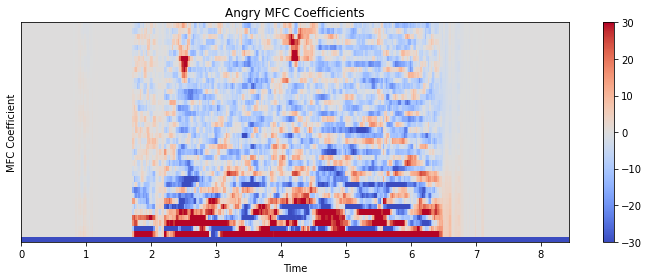

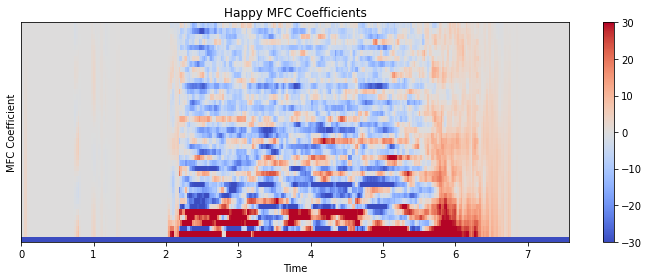

In [42]:
from matplotlib.colors import Normalize
mfc_coefficients = librosa.feature.mfcc(y=angry_waveform, sr=sample_rate, n_mfcc=40)
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfc_coefficients, x_axis='time',norm=Normalize(vmin=-30,vmax=30))
plt.colorbar()
plt.yticks(())
plt.ylabel('MFC Coefficient')
plt.title('Angry MFC Coefficients')
plt.tight_layout()
                                        
mfc_coefficients = librosa.feature.mfcc(y=happy_waveform, sr=sample_rate, n_mfcc=40)
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfc_coefficients, x_axis='time',norm=Normalize(vmin=-30,vmax=30))
plt.colorbar()
plt.yticks(())
plt.ylabel('MFC Coefficient')
plt.title('Happy MFC Coefficients')
plt.tight_layout()

Positive MFCCs correspond to low-frequency regions of the cepstrum, and negative MFFCs to high-frequency.

We see the Angry voice has a much greater proportion of positive MFFCs, corresponding to a lower voice pitch compared to the Happy voice. Makes sense - a happy voice carries a lighter tone and a higher pitch.

### Mel Spectrograms and Mel-Frequency Cepstrums

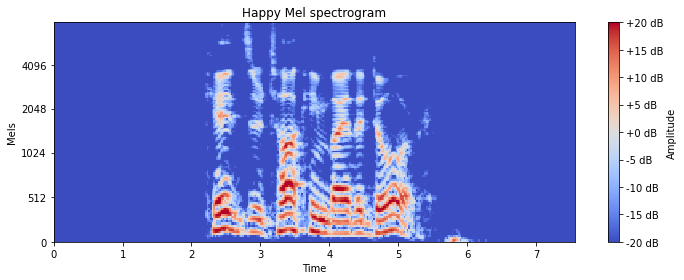

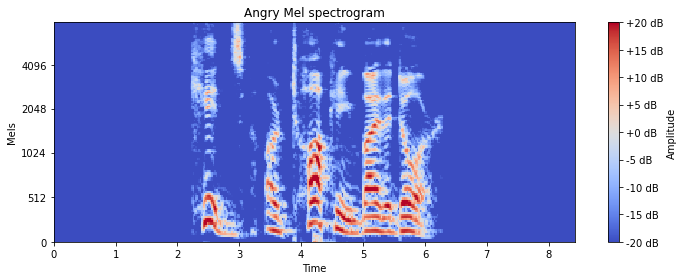

In [43]:
melspectrogram = librosa.feature.melspectrogram(y=happy_waveform, sr=sample_rate, n_mels=128, fmax=8000)
plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.power_to_db(S=melspectrogram, ref=np.mean),y_axis='mel',fmax=8000, x_axis='time', norm=Normalize(vmin=-20,vmax=20))
plt.colorbar(format='%+2.0f dB',label='Amplitude')
plt.ylabel('Mels')
plt.title('Happy Mel spectrogram')
plt.tight_layout()

melspectrogram = librosa.feature.melspectrogram(y=angry_waveform, sr=sample_rate, n_mels=128, fmax=8000)
plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.power_to_db(S=melspectrogram, ref=np.mean),y_axis='mel',fmax=8000, x_axis='time', norm=Normalize(vmin=-20,vmax=20))
plt.colorbar(format='%+2.0f dB',label='Amplitude')
plt.ylabel('Mels')
plt.title('Angry Mel spectrogram')
plt.tight_layout()

In [44]:
data['Emotion'].value_counts()

sad          192
angry        192
happy        192
disgust      192
fearful      192
surprised    192
calm         192
neutral       96
Name: Emotion, dtype: int64

In [48]:
data['Emotion'].sample(5)

280       fearful
799         happy
1436    surprised
616         happy
494         happy
Name: Emotion, dtype: object

In [185]:
data.sample(5)

File  Modality  Vocal    Emotion  Intensity  \
856  03-01-03-02-01-01-22.wav         3      1      happy          2   
502  03-01-04-01-02-01-17.wav         3      1        sad          1   
984  03-01-04-02-01-01-24.wav         3      1        sad          2   
957  03-01-08-02-01-02-23.wav         3      1  surprised          2   
269  03-01-05-01-01-02-13.wav         3      1      angry          1   

     Statement  Repetition  Actor  
856          1           1     22  
502          2           1     17  
984          1           1     24  
957          1           2     23  
269          1           2     13

In [77]:
list(data.sample()["File"])[0]

'03-01-03-02-01-01-19.wav'

c:\users\acer\appdata\local\programs\python\python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


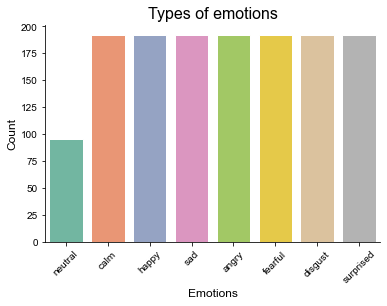

In [78]:
plt.title('Types of emotions', size=16)
import seaborn as sns
sns.set(style="darkgrid")
sns.countplot(data.Emotion, palette="Set2")
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
plt.xticks(rotation=45)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [80]:
data

File  Modality  Vocal    Emotion  Intensity  \
0     03-01-01-01-01-01-01.wav         3      1    neutral          1   
1     03-01-01-01-01-02-01.wav         3      1    neutral          1   
2     03-01-01-01-02-01-01.wav         3      1    neutral          1   
3     03-01-01-01-02-02-01.wav         3      1    neutral          1   
4     03-01-02-01-01-01-01.wav         3      1       calm          1   
...                        ...       ...    ...        ...        ...   
1435  03-01-08-01-02-02-09.wav         3      1  surprised          1   
1436  03-01-08-02-01-01-09.wav         3      1  surprised          2   
1437  03-01-08-02-01-02-09.wav         3      1  surprised          2   
1438  03-01-08-02-02-01-09.wav         3      1  surprised          2   
1439  03-01-08-02-02-02-09.wav         3      1  surprised          2   

      Statement  Repetition  Actor  Emotion_ID  
0             1           1      1           1  
1             1           2      1           1  
2             2           1      1           1  
3             2           2      1           1  
4             1           1      1           2  
...         ...         ...    ...         ...  
1435          2           2      9           8  
1436          1           1      9           8  
1437          1           2      9           8  
1438          2           1      9           8  
1439          2           2      9           8  

[1440 rows x 9 columns]

### Conventional ML 

In [48]:
info_df = pd.read_csv('Ravdess_annotations2.csv')

In [49]:
info_df

File    Emotion  Actor  Emotion_ID
0     03-01-01-01-01-01-01.wav    neutral      1           1
1     03-01-01-01-01-02-01.wav    neutral      1           1
2     03-01-01-01-02-01-01.wav    neutral      1           1
3     03-01-01-01-02-02-01.wav    neutral      1           1
4     03-01-02-01-01-01-01.wav       calm      1           2
...                        ...        ...    ...         ...
1435  03-01-08-01-02-02-09.wav  surprised      9           8
1436  03-01-08-02-01-01-09.wav  surprised      9           8
1437  03-01-08-02-01-02-09.wav  surprised      9           8
1438  03-01-08-02-02-01-09.wav  surprised      9           8
1439  03-01-08-02-02-02-09.wav  surprised      9           8

[1440 rows x 4 columns]

In [50]:
classes_code = {v:k for k,v in zip(info_df["Emotion"], info_df["Emotion_ID"])}
print(classes_code)

{1: 'neutral', 2: 'calm', 3: 'happy', 4: 'sad', 5: 'angry', 6: 'fearful', 7: 'disgust', 8: 'surprised'}


In [57]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

scaler = StandardScaler()
# keep our unscaled features just in case we need to process them alternatively
features_scaled = Feature
features_scaled = scaler.fit_transform(features_scaled)

scaler = MinMaxScaler()
# keep our unscaled features just in case we need to process them alternatively
features_minmax = Feature
features_minmax = scaler.fit_transform(features_minmax)

In [58]:
############ Unscaled test/train set #############
X_train, X_test, y_train, y_test = train_test_split(
    Feature, 
    Label, 
    test_size=0.2, 
    random_state=69
)

############ Standard Scaled test/train set ###########
# The labels/classes (y_train, y_test) never change, keep old values 
X_train_scaled, X_test_scaled, _, _ = train_test_split(
    features_scaled, 
    Label, 
    test_size=0.2, 
    random_state=69
)

############# MinMax Scaled test/train set ###############
# The labels/classes (y_train, y_test) never change, keep old values 
X_train_minmax, X_test_minmax, _, _ = train_test_split(
    features_scaled, 
    Label, 
    test_size=0.2, 
    random_state=69
)

In [59]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

classification_models = [
    KNeighborsClassifier(),#(3),
    SVC(kernel='linear'),#, C=0.025),
    SVC(kernel='rbf'),
    DecisionTreeClassifier(),#max_depth=5),
    RandomForestClassifier(),#max_depth=5, n_estimators=10, max_features=1),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

scores = []
for model in classification_models:
    model.fit(X_train_scaled, y_train)
    score = model.score(X_test_scaled, y_test)
    model_name = type(model).__name__
    if model_name=='SVC' and model.kernel=='rbf': model_name+=' RBF kernel'
    scores.append((model_name,(f'{100*score:.2f}%')))
# Make it pretty
scores_df = pd.DataFrame(scores,columns=['Classifier','Accuracy Score'])
scores_df.sort_values(by='Accuracy Score',axis=0,ascending=False)

c:\users\acer\appdata\local\programs\python\python37\lib\site-packages\sklearn\discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Classifier Accuracy Score
2                 SVC RBF kernel         52.78%
4         RandomForestClassifier         50.69%
0           KNeighborsClassifier         47.92%
1                            SVC         40.28%
7  QuadraticDiscriminantAnalysis         36.46%
6                     GaussianNB         35.42%
3         DecisionTreeClassifier         33.33%
5             AdaBoostClassifier         27.78%

In [60]:
def feature_extractor(path):
    data, simple_rate = librosa.load(path)
    data = librosa.feature.mfcc(data,n_mfcc=128)
    data = np.mean(data,axis=1)
    return data

In [53]:
Feature =  []
Label = []
for i,rows in tqdm(info_df.iterrows()):
    path = 'Akter/' + 'Actor' + str(rows['Actor']) + '/' + str(rows['File'])
    Feature.append(feature_extractor(path))
    Label.append(rows['Emotion_ID'])
Feature = np.array(Feature)
Label = np.array(Label)
Feature.shape, Label.shape

1440it [05:23,  4.45it/s]


((1440, 128), (1440,))

In [62]:
from sklearn.svm import SVC

model = SVC(
    C=10,
    gamma='auto',
    kernel='rbf',
    random_state=69
    
)

model.fit(X_train, y_train)

print(f'SVC Model\'s accuracy on training set is {100*model.score(X_train, y_train):.2f}%')
print(f'SVC Model\'s accuracy on test set is {100*model.score(X_test, y_test):.2f}%')

SVC Model's accuracy on training set is 100.00%
SVC Model's accuracy on test set is 46.53%


In [63]:
from sklearn.neighbors import KNeighborsClassifier

####### Default kNN  ########
model = KNeighborsClassifier(
)

model.fit(X_train, y_train)

print(f'Default kNN Model\'s accuracy on training set is {100*model.score(X_train, y_train):.2f}%')
print(f'Default kNN Model\'s accuracy on test set is {100*model.score(X_test, y_test):.2f}%\n')

##### (hastily) tuned kNN ######
model = KNeighborsClassifier(
    n_neighbors = 5,
    weights = 'distance',
    algorithm = 'brute',
    leaf_size = '30',
    n_jobs=4
)

model.fit(X_train, y_train)

print(f'kNN Model\'s accuracy on training set is {100*model.score(X_train, y_train):.2f}%')
print(f'kNN Model\'s accuracy on test set is {100*model.score(X_test, y_test):.2f}%')

Default kNN Model's accuracy on training set is 66.58%
Default kNN Model's accuracy on test set is 44.10%

kNN Model's accuracy on training set is 100.00%
kNN Model's accuracy on test set is 48.26%


In [64]:
from sklearn.ensemble import RandomForestClassifier

####### Default Random Forest ########
model = RandomForestClassifier(
    random_state=69
)

model.fit(X_train, y_train)

print(f'Default Random Forest Model\'s accuracy on training set is {100*model.score(X_train, y_train):.2f}%')
print(f'Default Random Forest Model\'s accuracy on test set is {100*model.score(X_test, y_test):.2f}%\n')


########## Tuned Random Forest #######
model = RandomForestClassifier(
    n_estimators = 500, 
    criterion ='entropy',
    warm_start = True,
    max_features = 'sqrt',
    oob_score = 'True', # more on this below
    random_state=69  
) 

model.fit(X_train, y_train)

print(f'Random Forest Model\'s accuracy on training set is {100*model.score(X_train, y_train):.2f}%')
print(f'Random Forest Model\'s accuracy on test set is {100*model.score(X_test, y_test):.2f}%')

Default Random Forest Model's accuracy on training set is 100.00%
Default Random Forest Model's accuracy on test set is 51.74%

Random Forest Model's accuracy on training set is 100.00%
Random Forest Model's accuracy on test set is 53.12%


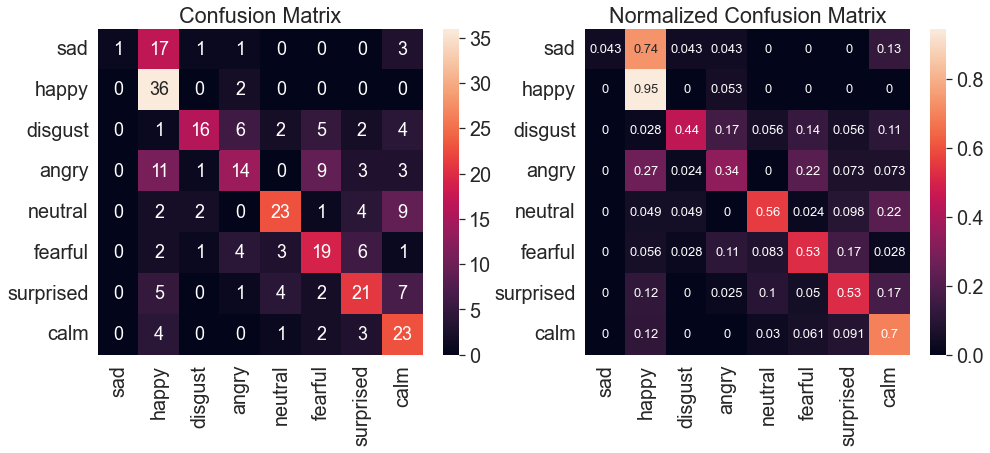

In [65]:
from sklearn.metrics import confusion_matrix
import seaborn as sn

test_emotion_predictions = model.predict(X_test)
test_emotion_groundtruth = y_test

# build confusion matrix and normalized confusion matrix
conf_matrix = confusion_matrix(test_emotion_groundtruth, test_emotion_predictions)
conf_matrix_norm = confusion_matrix(test_emotion_groundtruth, test_emotion_predictions,normalize='true')

# set labels for matrix axes from emotions
emotions = { 'neutral',  'calm',  'happy',  'sad',  'angry',  'fearful', 'disgust',  'surprised'}
emotion_name = [emotion for emotion in emotions]

# make a confusion matrix with labels using a DataFrame
confmatrix_df = pd.DataFrame(conf_matrix, index=emotion_name, columns=emotion_name)
confmatrix_df_norm = pd.DataFrame(conf_matrix_norm, index=emotion_name, columns=emotion_name)

# plot confusion matrices
plt.figure(figsize=(16,6))
sn.set(font_scale=1.8) # emotion label and title size
plt.subplot(1,2,1)
plt.title('Confusion Matrix')
sn.heatmap(confmatrix_df, annot=True, annot_kws={"size": 18}) #annot_kws is value font
plt.subplot(1,2,2)
plt.title('Normalized Confusion Matrix')
sn.heatmap(confmatrix_df_norm, annot=True, annot_kws={"size": 13}) #annot_kws is value font

plt.show()

### CNN 

In [66]:
def read_wav_file(path, file):
    data, samplerate = sf.read(path+file)
    return data, samplerate


def extract_mfcc(wav_file_name):
    y, sr = librosa.load(wav_file_name)
    mfccs = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40).T,axis=0)
    
    return mfccs

def create_data_loader(train_data, batch_size):
    train_dataloader = DataLoader(train_data, batch_size=batch_size)
    return train_dataloader

def train_single_epoch(model, data_loader, loss_fn, optimiser, device):
    for input, target in data_loader:
        input, target = input.to(device), target
        
        prediction = model(input)
        loss = loss_fn(prediction, target)

        optimiser.zero_grad()
        loss.backward()
        optimiser.step()

    print(f"loss: {loss.item()}")


def train(model, data_loader, loss_fn, optimiser, device, epochs):
    for i in range(epochs):
        print(f"Epoch {i+1}")
        train_single_epoch(model, data_loader, loss_fn, optimiser, device)
        print("---------------------------")
    print("Training is finished")


In [67]:
class CNNNetwork(nn.Module):

    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=16,
                kernel_size=3,
                stride=1,
                padding=2
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels=16,
                out_channels=32,
                kernel_size=3,
                stride=1,
                padding=2
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(
                in_channels=32,
                out_channels=64,
                kernel_size=3,
                stride=1,
                padding=2
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(
                in_channels=64,
                out_channels=128,
                kernel_size=3,
                stride=1,
                padding=2
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(128 * 5 * 4, 10)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, input_data):
        x = self.conv1(input_data)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.flatten(x)
        logits = self.linear(x)
        predictions = self.softmax(logits)
        return predictions

In [68]:
cnn = CNNNetwork()
summary(cnn, (1, 64, 44))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 66, 46]             160
              ReLU-2           [-1, 16, 66, 46]               0
         MaxPool2d-3           [-1, 16, 33, 23]               0
            Conv2d-4           [-1, 32, 35, 25]           4,640
              ReLU-5           [-1, 32, 35, 25]               0
         MaxPool2d-6           [-1, 32, 17, 12]               0
            Conv2d-7           [-1, 64, 19, 14]          18,496
              ReLU-8           [-1, 64, 19, 14]               0
         MaxPool2d-9             [-1, 64, 9, 7]               0
           Conv2d-10           [-1, 128, 11, 9]          73,856
             ReLU-11           [-1, 128, 11, 9]               0
        MaxPool2d-12            [-1, 128, 5, 4]               0
          Flatten-13                 [-1, 2560]               0
           Linear-14                   

In [69]:
annotations_file_train = 'Ravdess_annotations_train.csv'
annotations_file_val = 'Ravdess_annotations_validation.csv'

audio_dir = 'Actors'

sample_rate = 22050
mel_spectrogram = torchaudio.transforms.MelSpectrogram(sample_rate, n_fft=1024, hop_length=512, n_mels=64)
num_samples = 22050

batch_size = 128
epochs = 60
learning_rate = 0.001

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

rvds_train = Ravdess(annotations_file_train, audio_dir, mel_spectrogram, sample_rate, num_samples, device)
rvds_val = Ravdess(annotations_file_val, audio_dir, mel_spectrogram, sample_rate, num_samples, device)

train_dataloader = create_data_loader(rvds_train, batch_size)
val_dataloader = create_data_loader(rvds_val, batch_size)

cnn = CNNNetwork()
loss_fn = nn.CrossEntropyLoss()
optimiser = torch.optim.Adam(cnn.parameters(),
                                 lr=learning_rate)

train(cnn, train_dataloader, loss_fn, optimiser, device, epochs)

Epoch 1
loss: 2.2778286933898926
---------------------------
Epoch 2
loss: 2.2592084407806396
---------------------------
Epoch 3
loss: 2.263131856918335
---------------------------
Epoch 4
loss: 2.245861530303955
---------------------------
Epoch 5
loss: 2.2440340518951416
---------------------------
Epoch 6
loss: 2.2486610412597656
---------------------------
Epoch 7
loss: 2.251359224319458
---------------------------
Epoch 8
loss: 2.2463314533233643
---------------------------
Epoch 9
loss: 2.2435710430145264
---------------------------
Epoch 10
loss: 2.2405593395233154
---------------------------
Epoch 11
loss: 2.239961624145508
---------------------------
Epoch 12
loss: 2.2345685958862305
---------------------------
Epoch 13
loss: 2.2277352809906006
---------------------------
Epoch 14
loss: 2.229167938232422
---------------------------
Epoch 15
loss: 2.22314190864563
---------------------------
Epoch 16
loss: 2.217778205871582
---------------------------
Epoch 17
loss: 2.21807360

### The Learning_curve

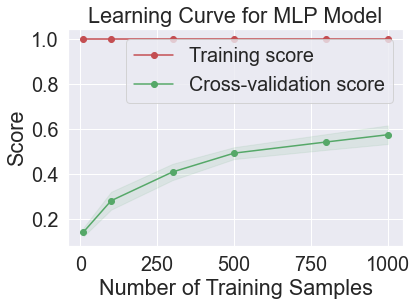

In [84]:
from sklearn.model_selection import learning_curve

# Build learning curve
train_sizes, train_scores, test_scores = learning_curve(
    model, 
    X=X_train, 
    y=y_train, 
    cv=10, 
    shuffle=True,
    random_state=69,
    n_jobs=4, 
    # We have (0.8*1440)/10 = 115/1150 training samples, 1035/1150 test samples  
    train_sizes=[10,100,300,500,800, 1000] # bounded at 1035 for this dataset for 10-fold cv
)
# Get errors for learning curve
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot learning curve
plt.figure()
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1,
                     color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
plt.title('Learning Curve for MLP Model')
plt.xlabel('Number of Training Samples')
plt.ylabel('Score')
plt.legend(loc="best")
plt.show()

### Conclusion 

   Network architecture is a critical factor in determining the computational complexity of a DNN; However, often simpler models with one hidden layer perform better than more complex models. The importance of evaluating the model correctly cannot be overstated: training data should be used strictly for training the model, validation data strictly for tuning the model, and test data strictly for evaluating the model after it has been tuned - the model should never be tuned to work. 
   Classic machine learning models such as Support Vector Machines (SVM), k Nearest Neighbours (kNN), and Random Forests had distinct advantages to deep neural networks in many tasks but did not match the performance of even the simplest deep neural network in the task of audio classification. Convolutional Neural Networks (CNNs) was excellent candidates for audio data classification, because features engineered on audio data such as spectrograms have marked resemblance to images, in which CNNs excel at recognition and discrimination between distinct patterns.
    